# SJByrnes using QuTip

This notebook has been inspired by the Qutip lecture notebook on the [Jaynes-Cumming-model](https://github.com/jrjohansson/qutip-lectures/blob/master/Lecture-1-Jaynes-Cumming-model.ipynb)  

(n.b. I think there might be an error in that lecture notebook as outlined [here](https://github.com/jrjohansson/qutip-lectures/issues/3))  and the work of [SJByrnes](https://coldfusionblog.net/2017/07/09/numerical-spin-boson-model-part-1/)


## Import the necessary libraries

In [281]:
%matplotlib inline
import numpy as np
import pandas as pd
from qutip import *
import plotly.express as px
import matplotlib.pyplot as plt

## Specify parameters for the system

In [282]:
E = 1.0                # two level energy difference
N = 3                 # number of phonon quanta needed to exite the atom
E_phonon = E / N       # phonon energy
M = 8             # maximum number of phonons to simulate
ng = 200            # number of different coupling strengths to try out (need 100 to reproduce SJByrnes Moiré pattern)
max_coupling = 0.7*E   # maximum atom phonon coupling 

## Set up a dataframe to hold the data we will calculate later

In [283]:
d = {"coupling":np.linspace(0,max_coupling,ng)}
for i in range(2*M):
    d[f"energy_{i}"] = np.zeros(ng)
    
df = pd.DataFrame(data=d)
#df

In [284]:
couplings=np.linspace(0,max_coupling,ng)


## Create operators for the hamiltonian

When creating operators for a multi-particle system, you do something like 

```tensor(operator on particle 1, operator on particle 2)```

If you don't want the operator to do any mixing between the particles then you will need to use the identiy operator `qeye` in one of the places

In [285]:
a  = tensor(destroy(M), qeye(2)) # phonon destruction operator
sm = tensor(qeye(M), sigmam())   # sigma_minus operator which is often called a lowering operator
sz = tensor(qeye(M),sigmaz())    # z component of the "spin" of the two level system

In [286]:
for index, row in df.iterrows():
    # c.f. https://coldfusionblog.net/2017/07/09/numerical-spin-boson-model-part-1/
    H = E*sz/2 + E_phonon*(a.dag()*a+0.5) + row.coupling*(a.dag() + a) * (sm + sm.dag())
    evals, ekets = H.eigenstates()
    df.iloc[index,1:] = evals/E_phonon
    
#print("\nSample row from the dataframe\n")



In [287]:
melt = df.melt(id_vars=["coupling"],var_name="level",value_name="energy")


In [288]:
fig = px.line(melt,x="coupling",y="energy",color="level",width=900,height=600)
fig.layout.showlegend = False 
fig.show()  # Don't use plot when you have M ~ 1000 it will likely grind to a hault
# fig.write_image("levels.png")


In [289]:
couplings=np.linspace(0,max_coupling,ng)
evals=[]  #different evals per different couplings
ekets=[]



## Make the plot easier storing Eigenvectors and Eigenvalues in a Matrix fromat

In [290]:
for ii in range(len(couplings)):
    # c.f. https://coldfusionblog.net/2017/07/09/numerical-spin-boson-model-part-1/
    H = E*sz/2 + E_phonon*(a.dag()*a+0.5) + couplings[ii]*(a.dag() + a) * (sm + sm.dag())
    evals_t, ekets_t = H.eigenstates()
    evals.append(evals_t/E_phonon)
    ekets.append(ekets_t)
    #df.iloc[index,1:] = evals/E_phonon

    
evals_m = np.matrix(evals)  #not dividing per E_phonon
ekets_m = np.matrix(ekets)
## evals[ N_coupling , 2*M = 2* max numebr of phonons  ]
## evals[ moving rightwards , moving upwards  ] in the above plot
## ekets[]  same thing for the ekets aka Eigenvstates  

#ekets_m[1,0] #Eigenstate of the first coupling non 0 and the ground state 0 

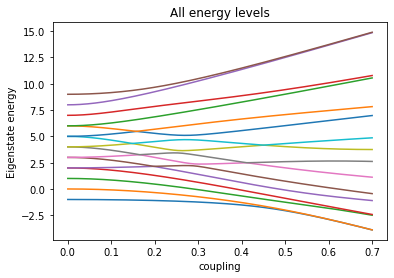

In [291]:
rows , columns =evals_m.shape
#plot with no correction of the E_phonon
for ii in range(columns):
    plt.plot(couplings,evals_m[:,ii])
    


axes = plt.gca()
plt.xlabel('coupling')
plt.ylabel('Eigenstate energy')
plt.title('All energy levels')

plt.show()

## Let's try to plot the coupling dependency of one single eigenvalue

In [292]:
N_comp=20 #number of vectors into which to decompose the which_state
which_state=6   # 1 means ground state,  which state 

if N_comp > 2*M:
    N_comp=2*M
    
if which_state > 2*M:
    which_state=2*M

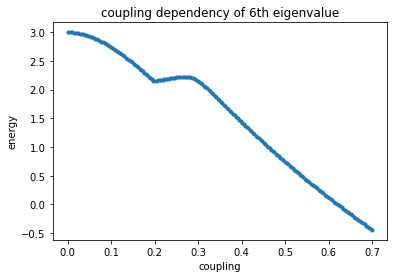

In [293]:

plt.plot(couplings,evals_m[:,which_state-1],'.')
plt.xlabel('coupling')
plt.ylabel('energy')
plt.title(f'coupling dependency of {which_state}th eigenvalue')
plt.show()


 There seems to be a sharp (left) and a smooth discontinuity (right)

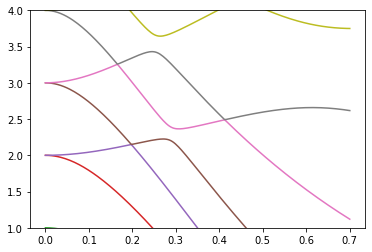

In [294]:
rows , columns =evals_m.shape
#plot with no correction of the E_phonon
for ii in range(columns):
    plt.plot(couplings,evals_m[:,ii])
    


axes = plt.gca()
axes.set_ylim([1,4])

plt.show()

## The discontinuity shows that if you follow the i-th eigenvalue, you are making a jump in the state.

Let's try to plot the components of the eigenstates as we go towards higher couplings 

Already from the 5th state (with current parapeters; first state that

In [295]:

c2=np.zeros((N_comp,len(couplings)))  
#c squared aka probabability for the eigenstates to be found in the first 
#N_comp basis componets (of the 0 interaction hamiltoniam) )

for ii in range(N_comp):
    for jj in range(len(couplings)):
        c0_dag_c = ( ekets_m[0,ii].dag() * ekets_m[jj, which_state-1 ]).full()  
        # ^ full() makes a Qobj into a array
        c2[ii,jj] = ( abs(c0_dag_c[0,0])**2 )
        
#if you want to see the components
Visual_c2=Qobj(c2)   #just to see 
## c2[ i-th eigenstate of 0 coupling , couplings  ]

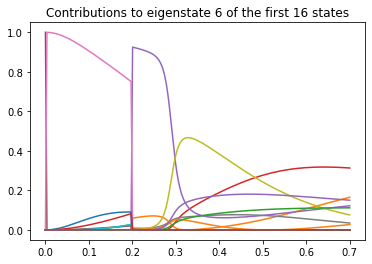

In [296]:
plt.figure()
for ii in range(N_comp):
    plt.plot(couplings,c2[ii,:], label=ii+1)
    
plt.title(f'Contributions to eigenstate {which_state} of the first {N_comp} states')    
#plt.legend()
plt.show()

In [ ]:
plt.fill_between(couplings, 0*c2[0,:], c2[0,:], label=0)

for ii in range(N_comp-1):
    plt.fill_between(couplings, np.sum(c2[0:ii+1,:], axis=0), np.sum(c2[0:ii+2,:], axis=0), label=ii+1)
#plt.legend()
plt.title(f'Contributions to eigenstate {which_state} of the first {N_comp} states') 
plt.show()

Here there is definitely something wrong! We have a sharp discontinuity in the states on the left.

We try now to follow the eigenstate of the "same" eigenvalue (follow the smooth curve), and see if its components are "continous"

In [ ]:
state=which_state  #ground state ==1
plt.figure(num=None, figsize=(12, 6), dpi=200, facecolor='w', edgecolor='k')

for ii in range(len(couplings)):
    eket_profile= abs( ekets_m[ii,state-1].full()  ) **2
    plt.plot(eket_profile*20*couplings[1]+couplings[ii], range(len(eket_profile)))

plt.title(f'The discontinuities (if any) show a sudden change in the eigenstate N={state}')
plt.xlabel('coupling')
plt.ylabel('Fock dimension; e.g. [0 1 0 0 0 0 0]')
plt.show()


## We should find the continous states

We will find the continous states by finding the closest eigenstates at each coupling, iterating from the minimal coupling to the highest, step by step.

In [ ]:
e_ord=np.zeros(ekets_m.shape) #preparing the real ordering of the eigenvalues/eigenstates
e_ord[0,:]=range(len(e_ord[0,:]))  #assigning values at 0 coupling

rows , columns =evals_m.shape #just to remeber the number of couplings and the number of eigenvalues

for ii in range(1,len(couplings)):
    
    for kk in range(columns):  #iteration for the comparison of the previous eigenstate
        distances=np.zeros(columns)
        
        for jj in range(columns):  #iteration for the comparison of the later eigenstate
            distances[jj] = np.linalg.norm(abs(ekets_m[ii-1,kk].full())**2-abs(ekets_m[ii,jj].full())**2)
            
        idx_min=np.argmin(distances)
        
        e_ord[ii, idx_min  ]=e_ord[ii-1,kk]


e_ord=e_ord.astype(int)
#e_ord  #matrix containing the right ordering for smooth transitions among couplings


In [ ]:
#ordered containers of eigenstates and eigencvalues

ekets_mo = ekets_m*0  
evals_mo = evals_m*0


for ii in range(len(couplings)):
    for kk in range(columns):
        ekets_mo[ ii, e_ord[ii,kk] ]= ekets_m[ii, kk]
        evals_mo[ ii, e_ord[ii,kk] ]= evals_m[ii, kk]
        

In [ ]:


for ii in range(columns):
    plt.plot(couplings,evals_mo[:,ii])
    


axes = plt.gca()
axes.set_ylim([1,4])

plt.show()

## Finally we have a proper assignment of the colored lines

In [ ]:

plt.plot(couplings,evals_mo[:,which_state-1],'.')
plt.xlabel('coupling')
plt.ylabel('energy')
plt.title(f'coupling dependency of {which_state}th eigenvalue')
plt.show()

In [ ]:
state=which_state  #ground state ==1
plt.figure(num=None, figsize=(12, 6), dpi=200, facecolor='w', edgecolor='k')

for ii in range(len(couplings)):
    eket_profile= abs( ekets_mo[ii,state-1].full()  ) **2
    plt.plot(eket_profile*20*couplings[1]+couplings[ii], range(len(eket_profile)))

plt.title(f'The discontinuities (if any) show a change in the eigenstate N={state}')
plt.xlabel('coupling')
plt.ylabel('Fock dimension; e.g. [0 1 0 0 0 0 0]')
plt.show()


In [ ]:

c2o=np.zeros((N_comp,len(couplings)))  
#c squared aka probabability for the eigenstates to be found in the first 
#N_comp basis componets (of the 0 interaction hamiltoniam) )

for ii in range(N_comp):
    for jj in range(len(couplings)):
        c0_dag_c = ( ekets_mo[0,ii].dag() * ekets_mo[jj, which_state-1 ]).full()  
        # ^ full() makes a Qobj into a array
        c2o[ii,jj] = ( abs(c0_dag_c[0,0])**2 )
        
#if you want to see the components
 
## c2[ i-th eigenstate of 0 coupling , couplings  ]

In [ ]:
plt.figure()
for ii in range(N_comp):
    plt.plot(couplings,c2o[ii,:], label=ii+1)
    
plt.title(f'Contributions to eigenstate {which_state} of the first {N_comp} states')    
#plt.legend()
plt.show()

In [ ]:
plt.fill_between(couplings, 0*c2o[0,:], c2o[0,:], label=0)

for ii in range(N_comp-1):
    plt.fill_between(couplings, np.sum(c2o[0:ii+1,:], axis=0), np.sum(c2o[0:ii+2,:], axis=0), label=ii+1)
#plt.legend()
plt.title(f'Contributions to eigenstate {which_state} of the first {N_comp} states') 
plt.show()